In [3]:
!pip install scikit-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Reloading Tuner from keras_tuner_dir/match_lstm_tuning/tuner0.json
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


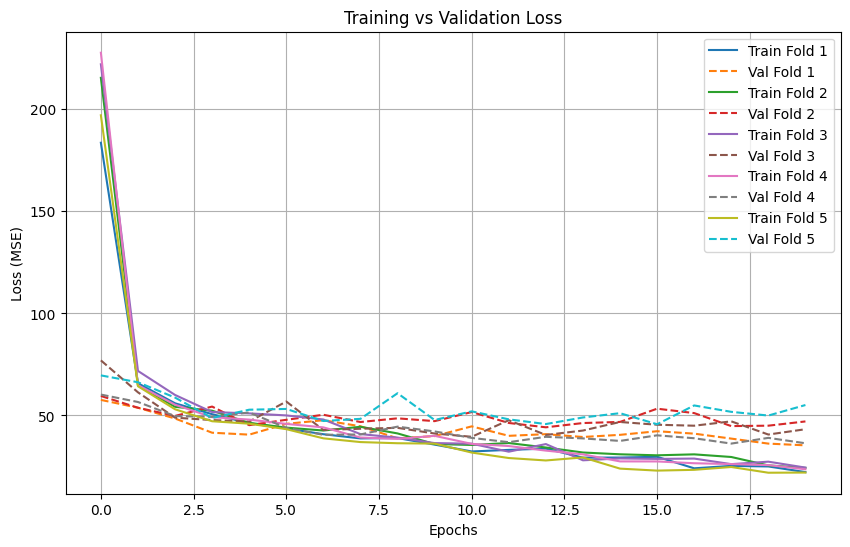


 Final Cross-Validated Metrics:
Average RMSE: 6.57
Average MAE : 3.94
Average MSE : 43.44
Average R2  : 0.8900


In [17]:

!pip install keras-tuner openpyxl

import pandas as pd
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

df = pd.read_excel("/content/ML Training Test Dataset.xlsx")

# group by Match ID and create sequences
grouped = df.groupby('Match ID 18Char')
sequences, targets, match_ids = [], [], []

for match_id, group in grouped:
    group = group.sort_values('Match Activation Date')
    features_df = group.drop(columns=['Match ID 18Char', 'Match Length'])

    for col in features_df.select_dtypes(include='object').columns:
        features_df[col] = LabelEncoder().fit_transform(features_df[col].astype(str))

    features_df = features_df.fillna(0)
    sequences.append(features_df.values)
    targets.append(group['Match Length'].iloc[0])
    match_ids.append(match_id)

X = pad_sequences(sequences, dtype='float32', padding='post', value=0.0)
y = np.array(targets)

# Normalize
scalers = [StandardScaler() for _ in range(X.shape[2])]
for i in range(X.shape[2]):
    col_vals = np.concatenate([x[:, i] for x in sequences])
    scalers[i].fit(col_vals.reshape(-1, 1))
    for j in range(len(X)):
        X[j, :, i] = scalers[i].transform(X[j, :, i].reshape(-1, 1)).flatten()

# Define hypermodel builder
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X.shape[1], X.shape[2])))
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(
        units=hp.Int("lstm_units_1", 32, 128, step=32),
        return_sequences=hp.Boolean("return_seq", default=False)
    ))
    if hp.Boolean("add_second_lstm"):
        model.add(Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1)))
        model.add(LSTM(units=hp.Int("lstm_units_2", 32, 64, step=32)))

    model.add(Dropout(hp.Float("dropout_final", 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Int("dense_units", 16, 64, step=16), activation="relu"))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
        loss="mse"
    )
    return model

# Tune using 1 fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(kf.split(X))[0]
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    directory="keras_tuner_dir",
    project_name="match_lstm_tuning"
)
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)
best_hp = tuner.get_best_hyperparameters(1)[0]

# Train and evaluate
mse_scores, rmse_scores, mae_scores, r2_scores = [], [], [], []
all_preds, all_true, all_match_ids = [], [], []
fold_losses = []

for train_index, val_index in kf.split(X):
    model = build_model(best_hp)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    preds = model.predict(X_val).flatten()

    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    all_preds.extend(preds)
    all_true.extend(y_val)
    all_match_ids.extend(np.array(match_ids)[val_index])
    fold_losses.append(history.history)

# Save predictions to excel
df_preds = pd.DataFrame({
    'Match ID 18Char': all_match_ids,
    'Predicted Match Length': all_preds,
    'Actual Match Length': all_true
})
df_final = df.drop_duplicates(subset='Match ID 18Char').merge(df_preds, on='Match ID 18Char', how='left')
df_final.to_excel("/content/ML_with_Tuned_Predictions.xlsx", index=False)

# Plot loss curves
plt.figure(figsize=(10, 6))
for i, losses in enumerate(fold_losses):
    plt.plot(losses['loss'], label=f'Train Fold {i+1}')
    plt.plot(losses['val_loss'], linestyle='--', label=f'Val Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Final Metrics
print("\n Final Cross-Validated Metrics:")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE : {np.mean(mae_scores):.2f}")
print(f"Average MSE : {np.mean(mse_scores):.2f}")
print(f"Average R2  : {np.mean(r2_scores):.4f}")
